In [1]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score as f1_scorer
from sklearn.metrics import confusion_matrix
import corpus as corpus_class
from filters import std_filters
from feature_extractors import tfidf, multinomial_model
import categories
import numpy as np
from scipy import sparse
import csv, pickle

corpus = corpus_class.corpus( categories.categories() )
corpus.load("question_train.csv", "question_category_train.csv")
corpus.process(**std_filters(), corpus_size=-1)
corpus.save()

In [2]:
corpus = corpus_class.load_from_file()

In [11]:
cropus = corpus.cv_split(3)

In [16]:
corpus = next(cropus)

# Wilcoxon - Tests

In [11]:
from scipy.stats import wilcoxon

def wilcoxon_cv(corpus, clf1, clf2, par1={}, par2={}, n_folds=35):
    corpus.cv_split(n_folds)
    f1s_clf1 = []
    f1s_clf2 = []
    for corpus in corpus:
        corpus.make_features(**par1)
        clf1.fit(corpus.X_tr, corpus.y_tr)
        y_pred1 = clf1.predict(corpus.X_te)
        f1_clf1 = f1_scorer(corpus.y_te, y_pred1, average="macro")
        
        corpus.make_features(**par2)
        clf2.fit(corpus.X_tr, corpus.y_tr)
        y_pred2 = clf2.predict(corpus.X_te)
        f1_clf2 = f1_scorer(corpus.y_te, y_pred2, average="macro")
        
        f1s_clf1 += [ f1_clf1 ]
        f1s_clf2 += [ f1_clf2 ]
    
    w = wilcoxon(f1s_clf1, f1s_clf2)
    return w, f1s_clf1, f1s_clf2

In [45]:
clf1 = RandomForestClassifier(n_estimators=20,max_features=100)
clf2 = RandomForestClassifier(n_estimators=20,max_features=100)
par1 = {"M":3500, "feature_extractor": tfidf}
par2 = {"M":3500, "feature_extractor": multinomial_model}

w, f1s_clf1, f1s_clf2 = wilcoxon_cv(corpus, clf1, clf2, par1=par1, par2=par2)

print(w, f1s_clf1, f1s_clf2)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in l

WilcoxonResult(statistic=56.0, pvalue=2.2134124905266775e-05) [0.46908069911526501, 0.48475256106422587, 0.45161265678966395, 0.4272439475561477, 0.47203363756205702, 0.39317330771865411, 0.44836895963475715, 0.51521468064576958, 0.46478552521380073, 0.41124767310024951, 0.48170287044977406, 0.48853335841587581, 0.48169740303906738, 0.49721606314315858, 0.52275009206303724, 0.5106456395742508, 0.4143134731408688, 0.43917421095967202, 0.47613283003759371, 0.50441204418044305, 0.48923209844278331, 0.43991444777023908, 0.46962549113339686, 0.49073565736408498, 0.47036279871696379, 0.448077364919369, 0.47452287303955215, 0.4630797384200816, 0.51500777182175161, 0.43911065629349705, 0.47146406263241036, 0.4532747883496282, 0.49635623420561303, 0.51639540700349773, 0.45840370267148206] [0.45388909308287329, 0.4279416384134862, 0.41437860129475945, 0.41673459912472804, 0.4473530680528866, 0.36461064246329805, 0.43315929738235015, 0.48731377013322119, 0.43846087641965686, 0.41475049672062853, 

In [38]:
clf1 = LogisticRegression(C=2)
clf2 = MultinomialNB(alpha=0.01)
w, f1s_clf1, f1s_clf2 = wilcoxon_cv(corpus, clf1, clf2)
print(w)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.501849183681 0.500227130138
0.5318180516 0.557744748921
0.53475615859 0.468589982137
0.445890726583 0.438165269831
0.567206952634 0.573712929092
0.497591868687 0.512260078885
0.531693480098 0.530681420899
0.54179018291 0.510002907131
0.474618613323 0.575942280249
0.529764941966 0.552006032157
0.508477112787 0.557549707825
0.527979683933 0.533524580508
0.53443237193 0.530865237196
0.495443595822 0.548226230246
0.603916452365 0.601637110128
0.489653991361 0.510578316622
0.518919136657 0.508393824407
0.514056206499 0.53797345953
0.548088618925 0.54318881819
0.521399370382 0.54000350442
0.599256407515 0.574018369172
0.486338353666 0.496922912107
0.538580147546 0.518546324977
0.548416832637 0.584292869145
0.532357266012 0.519687477275
0.547985705516 0.512391104135
0.510334666213 0.552172055049
0.569477667957 0.538468653438
0.5699920704 0.591265527081
0.523640563006 0.491925798449
0.528462085012 0.517488975883
0.507909979023 0.492736914194
0.585439982698 0.546097643794
0.567371704355 0.581

In [49]:
A = np.array(f1s_clf1)
B = np.array(f1s_clf2)
C = np.abs(A - B)
sort = np.argsort(C)
R = (np.arange(len(C)) + 1)*np.sign(A-B)[sort]
print(np.sum(R[R>0]))
wilcoxon(A-B)

for a, b in zip(A,B):
    if a > b:
        print("->",a,b)
    else:
        print(a,"->",b)

-> 0.469080699115 0.453889093083
-> 0.484752561064 0.427941638413
-> 0.45161265679 0.414378601295
-> 0.427243947556 0.416734599125
-> 0.472033637562 0.447353068053
-> 0.393173307719 0.364610642463
-> 0.448368959635 0.433159297382
-> 0.515214680646 0.487313770133
-> 0.464785525214 0.43846087642
0.4112476731 -> 0.414750496721
-> 0.48170287045 0.466434880187
-> 0.488533358416 0.439407573462
0.481697403039 -> 0.48267216848
-> 0.497216063143 0.455821712879
-> 0.522750092063 0.506189436906
-> 0.510645639574 0.453740113378
-> 0.414313473141 0.409421939825
0.43917421096 -> 0.451850093127
-> 0.476132830038 0.433104261293
-> 0.50441204418 0.499335779874
-> 0.489232098443 0.446151537505
-> 0.43991444777 0.405934497222
0.469625491133 -> 0.482929056526
0.490735657364 -> 0.492097677353
0.470362798717 -> 0.480479945789
-> 0.448077364919 0.427898892679
-> 0.47452287304 0.463562836696
-> 0.46307973842 0.434494207345
-> 0.515007771822 0.456186031124
-> 0.439110656293 0.417437522212
-> 0.471464062632 0.4

# Corss-Validation

In [21]:
import time, csv, pickle
import itertools as it

def CV(corpus, clf_class, clf_name, clf_params, feat_params, n_folds, skipping_rule=None):
    file_name = "cv_results/" + clf_name
    file_name += time.strftime("_%Y-%m-%d_%H-%M", time.gmtime())
    header = ["id", "f1", "accuracy", "time"] + list(feat_params[0].keys()) + list(clf_params[0].keys())
    
    csv_file = open(file_name+".csv", 'w+')
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(header)
    
    pkl_file = open(file_name+".pkl", 'wb+')
    results = {}
    
    corpus.cv_split(n_folds)
    
    idx = 0
    for c_par, f_par in it.product(clf_params, feat_params):
        if not (skipping_rule is None):
            if skipping_rule(c_par, f_par):
                print("skip:",c_par,f_par)
                continue
        results[idx] = {}
        results[idx]['feat_params'] = f_par
        results[idx]['clf_params'] = c_par
        
        f1_scores, acc_scores, times = [], [], []
        
        fold = 0
        for coprus in corpus:
            results[idx][fold] = {}
            corpus.make_features(**f_par)
            
            t = time.time() ### Time measure A ###
            
            clf = clf_class(**c_par)
            clf.fit(corpus.X_tr, corpus.y_tr)
            y_pred = clf.predict(corpus.X_te)
            
            dt = time.time() - t ### Time measure B ###
            
            acc = clf.score(corpus.X_te, corpus.y_te)
            f1 = f1_scorer(corpus.y_te, y_pred, average="macro")
            
            f1_scores += [ f1 ]
            acc_scores += [ acc ]
            times += [ dt ]
            
            results[idx][fold]['acc_score'] = acc
            results[idx][fold]['y_pred'] = y_pred
            results[idx][fold]['f1_score'] = f1
            results[idx][fold]['time'] = dt
            
            fold += 1

        results[idx]['f1_score'] = np.mean(f1_scores)
        results[idx]['acc_score'] = np.mean(acc_scores)
        results[idx]['time'] = np.mean(times)
        
        row = [ idx ]
        row += [results[idx]['f1_score'], results[idx]['acc_score'], results[idx]['time']]
        row += list(f_par.values()) + list(c_par.values())
        csv_writer.writerow( row )
        print(row)
        
        corpus.reset()
        idx += 1
    
    pickle.dump(results, pkl_file)
    
    csv_file.close()
    pkl_file.close()

In [22]:
#cdf = [{"n_estimators":int(n), "max_features":1} for n in np.linspace(10,100,10)]
#test = [ RandomForestClassifier, "RandomForestClassifier", cdf, [{"M": 1265, "feature_extractor":tfidf}] ]

In [24]:
CV(corpus, *RandomForest_params(), 3, skipping_rule=RF_skipping_rule)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0, 0.33674820354711515, 0.43968513893045841, 0.37729628880818683, <function tfidf at 0x105e45e18>, 64, 'entropy', 20, 1]
[1, 0.39487879598793379, 0.4831135215243707, 0.75066765149434411, <function tfidf at 0x105e45e18>, 134, 'entropy', 20, 1]
[2, 0.44934851299985085, 0.51412001495028836, 1.1271789073944092, <function tfidf at 0x105e45e18>, 283, 'entropy', 20, 1]
[3, 0.47343479337547617, 0.53742300467218096, 1.8118483225504558, <function tfidf at 0x105e45e18>, 595, 'entropy', 20, 1]
[4, 0.4904380358206924, 0.55129701652024166, 2.6549056371053061, <function tfidf at 0x105e45e18>, 1252, 'entropy', 20, 1]
[5, 0.48100612163057183, 0.55074202679406647, 4.1769700845082598, <function tfidf at 0x105e45e18>, 2633, 'entropy', 20, 1]
[6, 0.47439039908075609, 0.55545420025401182, 5.4266966978708906, <function tfidf at 0x105e45e18>, 5537, 'entropy', 20, 1]
[7, 0.48815487106499927, 0.54886691225008699, 7.6346283753712969, <function tfidf at 0x105e45e18>, -1, 'entropy', 20, 1]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[8, 0.3409127097107027, 0.44079496368790033, 0.44087473551432294, <function tfidf at 0x105e45e18>, 64, 'entropy', 20, 2]
[9, 0.3922475891575401, 0.48401434911143015, 0.76366861661275232, <function tfidf at 0x105e45e18>, 134, 'entropy', 20, 2]
[10, 0.44535430391386804, 0.51377345854768242, 1.2548513412475586, <function tfidf at 0x105e45e18>, 283, 'entropy', 20, 2]
[11, 0.46358084606741246, 0.53242913097289557, 1.8435643513997395, <function tfidf at 0x105e45e18>, 595, 'entropy', 20, 2]
[12, 0.48109328341638474, 0.5468564156817306, 2.8718845844268799, <function tfidf at 0x105e45e18>, 1252, 'entropy', 20, 2]
[13, 0.47792529356467334, 0.54872871531659062, 3.7138409614562988, <function tfidf at 0x105e45e18>, 2633, 'entropy', 20, 2]
[14, 0.47250492264448124, 0.55198671231176943, 5.362678050994873, <function tfidf at 0x105e45e18>, 5537, 'entropy', 20, 2]
[15, 0.47909005323347725, 0.54539932512842337, 8.226701021194458, <function tfidf at 0x105e45e18>, -1, 'entropy', 20, 2]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[16, 0.33230737819765716, 0.43746678635875408, 0.50426570574442542, <function tfidf at 0x105e45e18>, 64, 'entropy', 20, 4]
[17, 0.39070429634181186, 0.48006146152396889, 0.69743522008260095, <function tfidf at 0x105e45e18>, 134, 'entropy', 20, 4]
[18, 0.4346436788504584, 0.50822717391331762, 1.3669706185658772, <function tfidf at 0x105e45e18>, 283, 'entropy', 20, 4]
[19, 0.45753449996940709, 0.53048699653121167, 1.8511723677317302, <function tfidf at 0x105e45e18>, 595, 'entropy', 20, 4]
[20, 0.47394946305593999, 0.54144985725773742, 3.0606714089711509, <function tfidf at 0x105e45e18>, 1252, 'entropy', 20, 4]
[21, 0.47451447306078648, 0.5467167908132532, 4.3697199821472168, <function tfidf at 0x105e45e18>, 2633, 'entropy', 20, 4]


KeyboardInterrupt: 

# Listing CV Results

In [17]:
from os import listdir
def versions(clf_name):
    vers = []
    for f in listdir("cv_results"):
        if (f[:len(clf_name)] == clf_name) & (f[-4:] == ".csv") :
            vers += [ f[:-4] ]
    vers.sort(reverse=True)
    for i,f in zip(range(len(vers)),vers):
        print("[",i,"]", f)
    return vers

In [79]:
def show_results(vers, idx):
    with open("cv_results/"+ vers[idx] + ".pkl", 'rb') as file:
        results = pickle.load(file)
        head = ["id", "f1_score", "acc_score", "M", "alpha", "time"]
        
        matrix = np.zeros((len(results), len(head)))
        f1_scores = -np.array([results[i]["f1_score"] for i in results])
        
        best_idx = f1_scores.argsort()
        
        print("{0:6} {1:15} {2:15} {3:15} {4:15} {5:15}".format(*head))
        for idx in best_idx:
            matrix[idx,:] = [idx, results[idx]['f1_score'], results[idx]['acc_score'],
                           results[idx]['feat_params']['M'], results[idx]['clf_params']['alpha'],
                           results[idx]['time'] ]
            
            line = "{0:<6} {f1_score:<15.3} {acc_score:<15.3} {feat_params[M]:<15}"
            line += "{clf_params[alpha]:<15} {time:<15.5}"
            
            print( line.format(idx, **results[idx]) )
        return matrix

In [80]:
versis = versions("MultinomialNB")

[ 0 ] MultinomialNB_2016-12-25_16-48


In [81]:
R = show_results(versis, 0)

id     f1_score        acc_score       M               alpha           time           
31     0.521           0.577           -1             0.01            0.02637        
30     0.518           0.575           5624           0.01            0.046903       
39     0.513           0.594           -1             0.1             0.03196        
36     0.513           0.571           1265           0.1             0.022988       
23     0.512           0.566           -1             0.001           0.030251       
22     0.511           0.567           5624           0.001           0.027225       
37     0.51            0.576           2667           0.1             0.019125       
28     0.51            0.567           1265           0.01            0.028035       
29     0.51            0.567           2667           0.01            0.019338       
20     0.508           0.565           1265           0.001           0.028823       
38     0.507           0.584           5624          

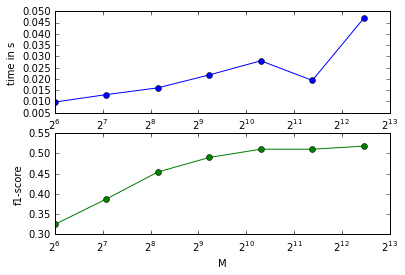

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt

filt = (R[:,4] == 0.01)

fig = plt.figure()

x = R[filt,3]
y = R[filt,1]
z = R[filt,5]

fig = plt.figure()

plt.subplot(211)
plt.semilogx(x, z, marker='o', basex=2)
#plt.plot(x, z, marker='o')
plt.ylabel('time in s')
plt.xlabel('C')

plt.subplot(212)
plt.semilogx(x, y, marker='o', c='g', basex=2)
#plt.plot(x, y, marker='o', c='g')
plt.ylabel('f1-score')
plt.xlabel('M')

plt.show()

# Parameter-Generating Functions

In [7]:
def MultinomialNB_params():
    clf_class = MultinomialNB
    clf_name = "MultinomialNB"
    clf_params = [{"alpha":M} for M in np.logspace(-5,1,7)]

    M_max = np.log2(len(corpus.all_terms))-1
    feat_params = [{"M":int(M)} for M in np.logspace(6,M_max,7, base=2)]
    feat_params += [{"M":-1}]

    return clf_class, clf_name, clf_params, feat_params

In [33]:
def LogisticRegression_params():
    clf_class = LogisticRegression
    clf_name = "LogisticRegression"
    clf_params = [{"C": round(C, 2), "penalty": 'l1', "solver": 'liblinear'} for C in np.logspace(-1,2,16, base=2)]
    #clf_params = [{"C":M, "penalty": 'l1', "solver": 'liblinear'} for M in np.linspace(2,4,5)]
    feat_params = [{"M":-1, "feature_extractor":multinomial_model}]
    
    return clf_class, clf_name, clf_params, feat_params

In [19]:
def RandomForest_params():
    clf_class = RandomForestClassifier
    clf_name = "RandomForestClassifier"
    #clf_params = [{"max_features": int(C), "n_estimators": 20} for C in np.logspace(0,8,9, base=2)]
    clf_params = [{"max_features": int(C),
                   "n_estimators": 20,
                   "criterion": 'entropy'
                  } for C in np.logspace(0,4,5, base=2)]
    
    M_max = np.log2(len(corpus.all_terms))-1
    feat_params = [{"M": int(M),
                    "feature_extractor":tfidf
                   } for M in np.logspace(6,M_max,7, base=2)]
    feat_params += [{"M":-1, "feature_extractor":tfidf}]
    
    return clf_class, clf_name, clf_params, feat_params

def RF_skipping_rule(c_par, f_par):
    # returns True if this pair of parameter should be skipped
    if f_par["M"] == -1:
        return False
    else:
        return c_par["max_features"] > f_par["M"]

In [20]:
RandomForest_params()

(sklearn.ensemble.forest.RandomForestClassifier,
 'RandomForestClassifier',
 [{'criterion': 'entropy', 'max_features': 1, 'n_estimators': 20},
  {'criterion': 'entropy', 'max_features': 2, 'n_estimators': 20},
  {'criterion': 'entropy', 'max_features': 4, 'n_estimators': 20},
  {'criterion': 'entropy', 'max_features': 8, 'n_estimators': 20},
  {'criterion': 'entropy', 'max_features': 16, 'n_estimators': 20}],
 [{'M': 64, 'feature_extractor': <function feature_extractors.tfidf>},
  {'M': 134, 'feature_extractor': <function feature_extractors.tfidf>},
  {'M': 283, 'feature_extractor': <function feature_extractors.tfidf>},
  {'M': 595, 'feature_extractor': <function feature_extractors.tfidf>},
  {'M': 1252, 'feature_extractor': <function feature_extractors.tfidf>},
  {'M': 2633, 'feature_extractor': <function feature_extractors.tfidf>},
  {'M': 5537, 'feature_extractor': <function feature_extractors.tfidf>},
  {'M': -1, 'feature_extractor': <function feature_extractors.tfidf>}])

# Box Plots

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def box_plot(corpus, clfs, f_pars, n_folds=3):
    corpus.cv_split(n_folds)
    m = len(corpus.cats)
    scores = {clf_name: np.zeros((n_folds, m+1)) for clf_name in clfs}
    f1_scores = {clf_name: np.zeros(n_folds) for clf_name in clfs}
    
    for corpus in corpus:
        i = corpus.current_fold -1
        
        for clf_name in clfs:
            clf = clfs[clf_name]
            f_par = f_pars[clf_name]
            
            corpus.make_features(**f_par)
            clf.fit(corpus.X_tr, corpus.y_tr)
            y_pred = clf.predict(corpus.X_te)
            
            f1_scores[clf_name][i] = f1_scorer(corpus.y_te, y_pred, average="macro")
            
            cv = confusion_matrix(corpus.y_te, y_pred)
            bingos = cv.diagonal()
            totals = cv.sum(axis=1)
            accs = bingos/totals
            
            scores[clf_name][i, 1:] = accs
            scores[clf_name][i, 0] = bingos.sum() / totals.sum()
    
    sco = next(iter(scores.values()))
    sort = (-sco[:,1:].mean(axis=0)).argsort()
    
    scores_ = {clf_name: np.zeros((n_folds, m+1)) for clf_name in clfs}
    for clf_name in clfs:
        scores_[clf_name][:,0] = scores[clf_name][:,0]
        scores_[clf_name][:,1:] = scores[clf_name][:,1:][:,sort]

    return scores, scores_, f1_scores, sort

In [44]:
with open('cv_results/box_plot_data.pkl', 'rb') as f:
    scores, scores_, f1_scores, sort = pickle.load(f)

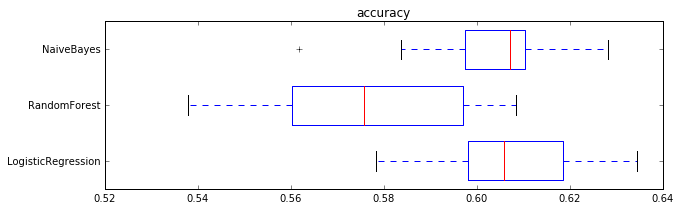

In [6]:
data = []
for clf_name in scores.keys():
    data.append(scores[clf_name][:,0])

plt.figure(figsize=(10, 3))
plt.title('accuracy')
plt.boxplot(data, vert=False, widths=0.7, meanline=True)
lables = np.append(['avarage'],corpus.cats[:])
plt.yticks(np.arange(3)+1, list(scores.keys()), rotation=0, ha='right')
plt.show() 

In [7]:
for clf_name in scores.keys():
    print(clf_name + " : " + str(scores[clf_name][:,0].mean()))

LogisticRegression : 0.606049909445
RandomForest : 0.578322790826
NaiveBayes : 0.604381072058


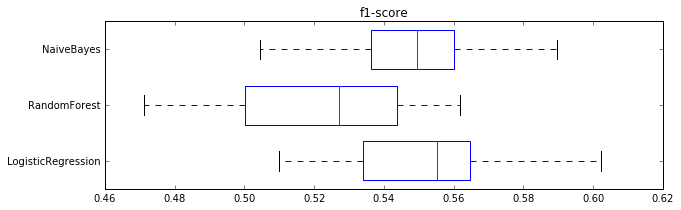

In [8]:
data = []
for clf_name in scores.keys():
    data.append(f1_scores[clf_name])

plt.figure(figsize=(10, 3))
plt.title('f1-score')
f1_box_res = plt.boxplot(data, vert=False, widths=0.7, meanline=True)
lables = np.append(['f1-score'],corpus.cats[:])
plt.yticks(np.arange(3)+1, list(scores.keys()), rotation=0, ha='right')
plt.show() 

In [9]:
for clf_name in scores.keys():
    print(clf_name + " : " + str(f1_scores[clf_name].mean()))

LogisticRegression : 0.552599767924
RandomForest : 0.52335942251
NaiveBayes : 0.549118229158


In [14]:
wilcoxon(f1_scores['NaiveBayes'], f1_scores['RandomForest'])

WilcoxonResult(statistic=19.0, pvalue=0.0013245375247995077)

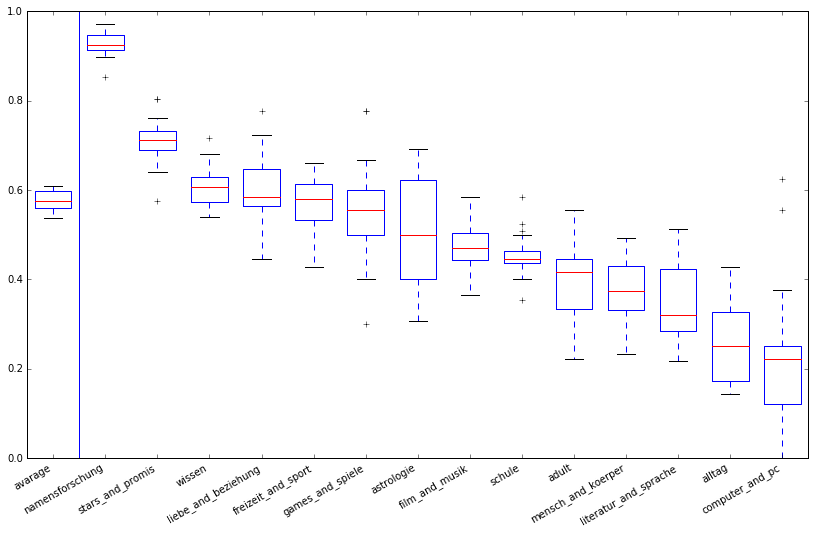

In [8]:
plt.figure(figsize=(14, 8))

sco = scores['RandomForest']
sort = (-sco[:,1:].mean(axis=0)).argsort()
sco[:,1:] =  sco[:,1:][:,sort]

plt.boxplot(sco, vert=True, widths=0.7)
lables = np.append(['avarage'],corpus.cats[:][sort])
plt.xticks(np.arange(15)+1, lables, rotation=30, ha='right')
plt.axvline(1.5, c='b')

plt.show() 

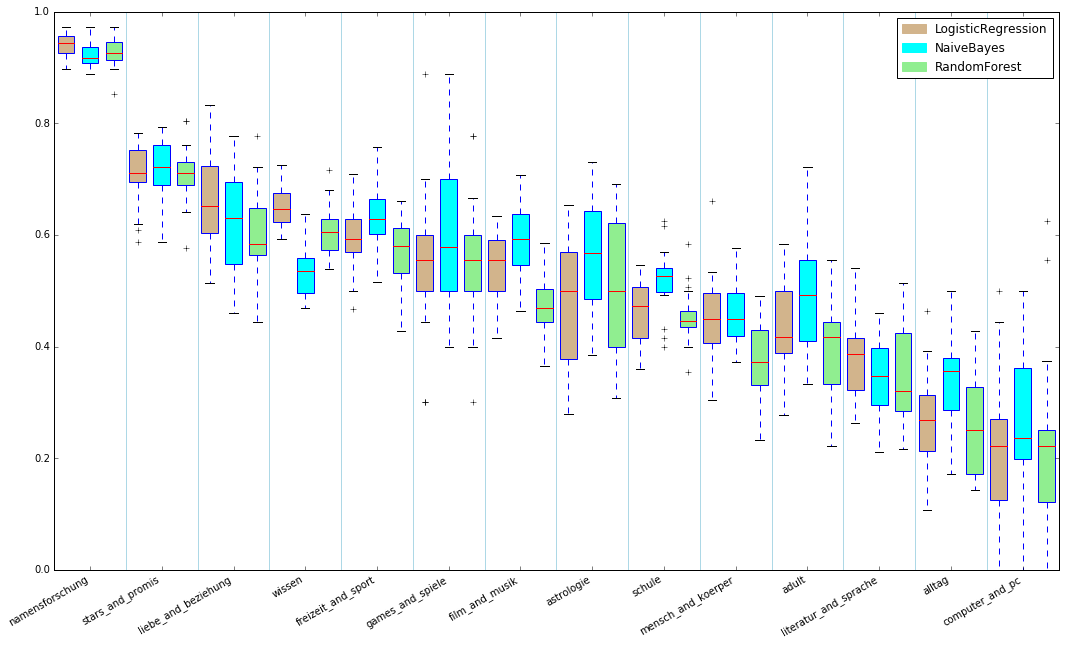

In [47]:
import matplotlib.patches as mpatches
plt.figure(figsize=(18, 10))

sco = scores['LogisticRegression']
sort = (-sco[:,1:].mean(axis=0)).argsort()

data = []
for i in sort+1:
    data.append(scores['LogisticRegression'][:,i])
    data.append(scores['NaiveBayes'][:,i])
    data.append(scores['RandomForest'][:,i])
                                       
box_plt = plt.boxplot(data, vert=True, widths=0.7, patch_artist=True)

#colors = ['cyan', 'lightblue', 'lightgreen', 'tan', 'pink']
colors = ['tan', 'cyan', 'lightgreen', 'tan', 'pink']

i = 0
for patch in box_plt['boxes']:
    patch.set_facecolor(colors[i%3])
    i += 1

lables = corpus.cats[:][sort]

plt.xticks(3*np.arange(14)+2, lables, rotation=30, ha='right')
for i in range(13):
    plt.axvline(i*3 + 3.5, c='lightblue')

lr_legend = mpatches.Patch(color='tan', label='LogisticRegression')
nb_legend = mpatches.Patch(color='cyan', label='NaiveBayes')
rf_legend = mpatches.Patch(color='lightgreen', label='RandomForest')
plt.legend(handles=[lr_legend, nb_legend, rf_legend])
    
plt.show() 

In [46]:
sort

array([ 2,  4,  9, 10,  8, 12, 11,  3,  0, 13,  7,  1,  6,  5])